<a href="https://colab.research.google.com/github/AnuThmsn/DNN_Estimation_of_CBF_and_ATT_ASL/blob/main/NN_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================
# ASL DNN vs NLLS COMPARISON
# Supervised NN (Mastropietro-style)
# ============================

import os
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from natsort import natsorted
from tqdm import tqdm

In [ ]:
from google.colab import drive
import os
import shutil

# Explicitly unmount the drive before mounting to ensure a clean state
if os.path.exists('/content/drive'):
    try:
        drive.flush_and_unmount()
    except ValueError:
        # Ignore error if drive was not mounted
        pass

# Removed the problematic code that was clearing the entire /content/drive contents
# Relying on drive.flush_and_unmount() and force_remount=True for a clean mount.

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/MyDrive/Multipld_project/sctimple/sctdata"

perf_folders = ["perf_1525", "perf_2025", "perf_2525", "perf_3025"]
M0_folders   = ["M0_1525",  "M0_2025",  "M0_2525",  "M0_3025"]
mask_folder  = os.path.join(BASE_DIR, "brain_mask")

# Output directory changed to be outside the Multipld_project data folder
OUTPUT_DIR = "/content/drive/MyDrive/Colab_Output/NN_ASL_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
PLDs = np.array([1.525, 2.025, 2.525, 3.025])
tau = 1.8
T1b = 1.65
R1a = 1 / T1b
alpha = 0.85
lmbda = 0.9
eps = 1e-12

In [ ]:
def load_dicom_volume(folder):
    files = natsorted([os.path.join(folder, f) for f in os.listdir(folder)])
    slices = [pydicom.dcmread(f) for f in files]
    slices.sort(key=lambda s: int(s.InstanceNumber))
    vol = np.stack([s.pixel_array for s in slices], axis=-1).astype(np.float32)

    px, py = map(float, slices[0].PixelSpacing)
    thk = float(slices[0].SliceThickness)
    affine = np.diag([px, py, thk, 1])
    return vol, affine

In [ ]:
T1b = 1.65; R1b = 1/T1b
T1t = 1.445; R1t = 1/T1t # T1 of tissue from Word doc

def buxton_signal(plds, f, att):
    # f is in ml/ml/s here
    # Scaling factor from Word document
    f_scaled = 2 * alpha * f * T1b # Note: Scaling often uses T1b or 1/R1a
    s = np.zeros_like(plds)
    for i, t in enumerate(plds):
        if t < att:
            s[i] = 0
        elif att <= t < att + tau:
            # Blood has traveled for 'att' in arteries, then (t-att) in tissue
            s[i] = f_scaled * np.exp(-att * R1b) * (1 - np.exp(-(t - att) * R1t))
        else:
            # Post-labeling: decay of the full bolus duration tau
            s[i] = f_scaled * np.exp(-att * R1b) * (1 - np.exp(-tau * R1t)) * \
                   np.exp(-(t - att - tau) * R1t)
    return s

In [ ]:
def generate_training_data(N=300_000):
    X, Y = [], []

    for _ in tqdm(range(N), desc="Simulating ASL signals"):
        cbf_ml = np.random.uniform(20, 90)
        att = np.random.uniform(0.5, 3.0)
        f = cbf_ml / (6000 * lmbda)

        sig = buxton_signal(PLDs, f, att)
        sig += np.random.normal(0, 0.02 * np.max(sig), sig.shape)

        X.append(sig)
        Y.append([cbf_ml, att])

    return np.array(X), np.array(Y)

In [ ]:
class ASLNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
X, Y = generate_training_data()

y_scaler = StandardScaler()
Y_std = y_scaler.fit_transform(Y)

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(Y_std, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=512, shuffle=True)

model = ASLNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(40):
    total = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"Epoch {epoch+1}: loss = {total/len(loader):.5f}")

Simulating ASL signals: 100%|██████████| 300000/300000 [00:16<00:00, 18739.22it/s]


Epoch 1: loss = 0.65147
Epoch 2: loss = 0.54612
Epoch 3: loss = 0.36251
Epoch 4: loss = 0.23821
Epoch 5: loss = 0.19105
Epoch 6: loss = 0.16404
Epoch 7: loss = 0.15139
Epoch 8: loss = 0.13645
Epoch 9: loss = 0.12698
Epoch 10: loss = 0.12396
Epoch 11: loss = 0.11691
Epoch 12: loss = 0.11562
Epoch 13: loss = 0.11175
Epoch 14: loss = 0.10691
Epoch 15: loss = 0.10731
Epoch 16: loss = 0.10525
Epoch 17: loss = 0.10533
Epoch 18: loss = 0.10082
Epoch 19: loss = 0.10127
Epoch 20: loss = 0.10150
Epoch 21: loss = 0.10153
Epoch 22: loss = 0.09580
Epoch 23: loss = 0.09562
Epoch 24: loss = 0.09323
Epoch 25: loss = 0.09568
Epoch 26: loss = 0.09607
Epoch 27: loss = 0.09353
Epoch 28: loss = 0.09468
Epoch 29: loss = 0.09422
Epoch 30: loss = 0.09293
Epoch 31: loss = 0.09331
Epoch 32: loss = 0.09329
Epoch 33: loss = 0.09305
Epoch 34: loss = 0.09264
Epoch 35: loss = 0.09260
Epoch 36: loss = 0.09095
Epoch 37: loss = 0.09295
Epoch 38: loss = 0.08994
Epoch 39: loss = 0.09082
Epoch 40: loss = 0.08997


In [ ]:
mask_vol, affine = load_dicom_volume(mask_folder)
mask = mask_vol > 0
sz = mask.shape

deltaM = np.zeros((*sz, 4))
M0 = np.zeros((*sz, 4))

for i in range(4):
    deltaM[..., i], _ = load_dicom_volume(os.path.join(BASE_DIR, perf_folders[i]))
    M0[..., i], _ = load_dicom_volume(os.path.join(BASE_DIR, M0_folders[i]))

In [ ]:
import numpy as np

# 1. SIMULATE TESTING DATA
# ========================
num_samples = 1000
# Simulate realistic ranges for CBF (ml/100g/min) and ATT (seconds)
# GM CBF: 40-80, WM CBF: 10-30; ATT: 0.5 to 2.0s
true_cbf = np.random.uniform(10, 90, num_samples)
true_att = np.random.uniform(0.5, 2.5, num_samples)

# Generate synthetic signals using your buxton_signal function
simulated_signals = np.zeros((num_samples, len(PLDs)))
for i in range(num_samples):
    # Ensure 'buxton_signal' takes `f` and `att` as inputs
    # Convert CBF (ml/100g/min) to f (mL/mL/s)
    f_sim = true_cbf[i] / (6000 * lmbda)
    simulated_signals[i] = buxton_signal(PLDs, f_sim, true_att[i])

# Adding small Gaussian noise to simulate real scanner conditions
noise = np.random.normal(0, 0.02 * np.mean(simulated_signals), simulated_signals.shape)
simulated_signals += noise

# 2. TESTING FUNCTIONS
# ====================
def print_parameter_ranges(cbf_map, att_map, label="Data"):
    """Prints the min and max for CBF and ATT"""
    print(f"\n--- Range Analysis: {label} ---")
    print(f"CBF Range: {np.min(cbf_map):.2f} to {np.max(cbf_map):.2f} ml/100g/min")
    print(f"ATT Range: {np.min(att_map):.2f} to {np.max(att_map):.2f} seconds")

# 3. EXECUTION
# ============

# A. Test on Simulated Data
# (Assuming 'model' is your trained DNN and 'y_scaler' is your fitted scaler)
sim_inputs = torch.tensor(simulated_signals, dtype=torch.float32)
with torch.no_grad():
    sim_preds_std = model(sim_inputs).numpy()
    sim_preds = y_scaler.inverse_transform(sim_preds_std)
    sim_cbf, sim_att = sim_preds[:, 0], sim_preds[:, 1]

print_parameter_ranges(true_cbf, true_att, label="Simulated Ground Truth")
print_parameter_ranges(sim_cbf, sim_att, label="Simulated Data Predictions")





--- Range Analysis: Simulated Ground Truth ---
CBF Range: 10.03 to 89.94 ml/100g/min
ATT Range: 0.51 to 2.50 seconds

--- Range Analysis: Simulated Data Predictions ---
CBF Range: 2.73 to 100.97 ml/100g/min
ATT Range: 0.52 to 2.99 seconds


In [ ]:
import torch
import numpy as np

# 1. Define 4 Manual Test Cases (Signal deltaM/M0 at different PLDs)
# PLDs used: [1.525, 2.025, 2.525, 3.025]
test_cases = {
    "Healthy Gray Matter (High CBF, Short ATT)": [0.035, 0.045, 0.042, 0.038],
    "Healthy White Matter (Low CBF, Short ATT)": [0.012, 0.015, 0.014, 0.013],
    "Stroke Core (Very Low CBF, Delayed ATT)":   [0.002, 0.005, 0.008, 0.009],
    "negative delta m": [-0.01, -0.005, 0.0, 0.002]
}

# 2. Put model in evaluation mode
model.eval()

print("--- Manual Model Testing ---")
for description, signal in test_cases.items():
    # Convert to numpy and reshape for the scaler (1 sample, 4 features)
    signal_arr = np.array(signal).reshape(1, -1)

    # The input signal to the model should NOT be scaled by y_scaler.
    # y_scaler is for scaling the *targets* (CBF, ATT) during training,
    # and for inverse transforming the *predictions* from the model.
    input_tensor = torch.tensor(signal_arr, dtype=torch.float32)

    # Inference
    with torch.no_grad():
        pred_std = model(input_tensor).numpy()
        # Inverse transform the model's output (predicted CBF and ATT)
        prediction = y_scaler.inverse_transform(pred_std)[0]
        pred_cbf = prediction[0]
        pred_att = prediction[1]

    print(f"\nCase: {description}")
    print(f"  Input Signal: {signal}")
    print(f"  Predicted CBF: {pred_cbf:.2f} ml/100g/min")
    print(f"  Predicted ATT: {pred_att:.2f} seconds")

--- Manual Model Testing ---

Case: Healthy Gray Matter (High CBF, Short ATT)
  Input Signal: [0.035, 0.045, 0.042, 0.038]
  Predicted CBF: 107.39 ml/100g/min
  Predicted ATT: 0.89 seconds

Case: Healthy White Matter (Low CBF, Short ATT)
  Input Signal: [0.012, 0.015, 0.014, 0.013]
  Predicted CBF: 70.95 ml/100g/min
  Predicted ATT: 0.78 seconds

Case: Stroke Core (Very Low CBF, Delayed ATT)
  Input Signal: [0.002, 0.005, 0.008, 0.009]
  Predicted CBF: 56.74 ml/100g/min
  Predicted ATT: 1.30 seconds

Case: negative delta m
  Input Signal: [-0.01, -0.005, 0.0, 0.002]
  Predicted CBF: 156.76 ml/100g/min
  Predicted ATT: 4.40 seconds


In [ ]:
ratios = [] # List to collect all valid DeltaM/M0 inputs

model.eval()
with torch.no_grad():
    for x in tqdm(range(sz[0]), desc="NN inference"):
        for y in range(sz[1]):
            for z in range(sz[2]):
                if not mask[x,y,z]:
                    continue

                dm = deltaM[x,y,z,:]
                m0 = np.mean(M0[x,y,z,:])

                if m0 <= 500:
                    continue

                # Calculate the ratio DeltaM / M0
                ratio = dm / (m0 + eps)
                ratios.append(ratio) # Store for range analysis

                inp = torch.tensor(ratio, dtype=torch.float32).unsqueeze(0)
                pred_std = model(inp)
                # ... (rest of your prediction code)
    print(m0)

# Analysis of the range
ratios_np = np.array(ratios)
print(f"DeltaM/M0 Global Min: {np.min(ratios_np):.5f}")
print(f"DeltaM/M0 Global Max: {np.max(ratios_np):.5f}")
print(f"DeltaM/M0 Global Mean: {np.mean(ratios_np):.5f}")

NN inference: 100%|██████████| 128/128 [00:31<00:00,  4.08it/s]


642.5
DeltaM/M0 Global Min: 0.01356
DeltaM/M0 Global Max: 1.96969
DeltaM/M0 Global Mean: 0.20416


In [ ]:
CBF = np.full(sz, np.nan)
ATT = np.full(sz, np.nan)

model.eval()
with torch.no_grad():
    for x in tqdm(range(sz[0]), desc="NN inference"):
        for y in range(sz[1]):
            for z in range(sz[2]):
                if not mask[x,y,z]:
                    continue

                dm = deltaM[x,y,z,:]
                m0 = np.mean(M0[x,y,z,:])

                if m0 <= 500:
                    continue

                inp = torch.tensor(dm / (m0 + eps), dtype=torch.float32).unsqueeze(0)
                pred_std = model(inp)
                pred = y_scaler.inverse_transform(pred_std.numpy())

                CBF[x,y,z] = pred[0,0]
                ATT[x,y,z] = pred[0,1]

NN inference: 100%|██████████| 128/128 [01:16<00:00,  1.67it/s]


In [ ]:
def analyze_model_outputs(predictions, label="Testing"):
    # predictions is expected to be [N, 2] where col 0 is CBF and col 1 is ATT
    cbf_results = predictions[:, 0]
    att_results = predictions[:, 1]

    print(f"=== {label} Results Summary ===")
    print(f"CBF -> Min: {cbf_results.min():.2f} | Max: {cbf_results.max():.2f} | Mean: {cbf_results.mean():.2f}")
    print(f"ATT -> Min: {att_results.min():.2f} | Max: {att_results.max():.2f} | Mean: {att_results.mean():.2f}")
    print("="*30)


In [ ]:
import numpy as np

# Filter out NaN values from CBF and ATT maps
valid_cbf = CBF[~np.isnan(CBF)]
valid_att = ATT[~np.isnan(ATT)]

# Combine into a single array for the analyze_model_outputs function
predictions_combined = np.stack([valid_cbf, valid_att], axis=1)

analyze_model_outputs(predictions_combined, label="DNN Predicted Maps")

=== DNN Predicted Maps Results Summary ===
CBF -> Min: 94.76 | Max: 155.02 | Mean: 119.23
ATT -> Min: -0.16 | Max: 1.00 | Mean: 0.87


In [ ]:
CBF_nii = nib.Nifti1Image(CBF.astype(np.float32), affine)
ATT_nii = nib.Nifti1Image(ATT.astype(np.float32), affine)

nib.save(CBF_nii, os.path.join(OUTPUT_DIR, "CBF_DNN_ml_100g_min.nii.gz"))
nib.save(ATT_nii, os.path.join(OUTPUT_DIR, "ATT_DNN_sec.nii.gz"))

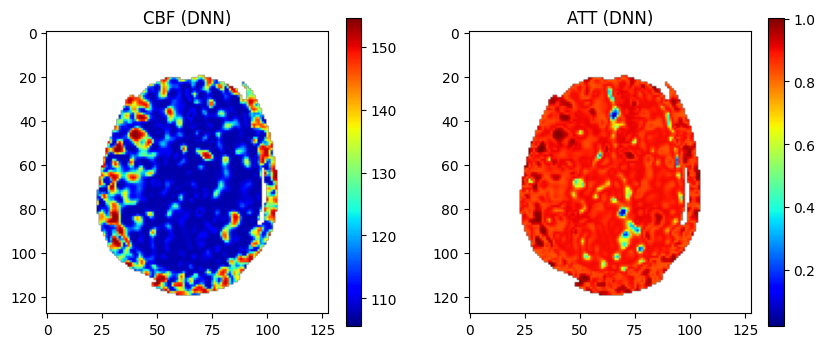

In [ ]:
z = sz[2] // 2

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(CBF[:,:,z], cmap="jet")
plt.title("CBF (DNN)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(ATT[:,:,z], cmap="jet")
plt.title("ATT (DNN)")
plt.colorbar()
plt.show()